In [ ]:
# Install required dependencies
import sys
import subprocess

def install_packages() -> None:
    """Install required packages if not already installed."""
    packages = [
        'pandas',
        'matplotlib',
        'librosa',
        'soundfile',
        'language_tool_python',
        'openai-whisper',
        'numpy'
    ]
    
    print("Installing required packages...")
    try:
        subprocess.check_call(
            [sys.executable, '-m', 'pip', 'install', '--quiet'] + packages,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        print("✓ All packages installed successfully")
    except subprocess.CalledProcessError as e:
        print(f"⚠ Warning: Some packages may not have installed correctly: {e}")
        print("  You can manually install with: pip install pandas matplotlib librosa")

# Run installation
install_packages()

📦 Installing required packages...
✓ All packages installed successfully
✓ All packages installed successfully


# Grammar Scoring Engine – End-to-End Demo

**Audio → ASR → NLP Features → Scoring**

---

## Purpose

This notebook demonstrates the complete pipeline for the **Grammar Scoring Engine from Voice Samples**, developed as part of an AI Research Internship assignment at SHL. The system evaluates spoken language proficiency by:

1. **Transcribing** audio using Whisper ASR
2. **Extracting** grammar errors, filler words, and fluency metrics
3. **Computing** a weighted 0-100 proficiency score based on research-backed criteria

This approach mimics real-world automated speech assessment used in talent evaluation and language testing.

## 1. Setup and Imports

**Prerequisites:** Run `pip install -r requirements.txt` before executing this notebook.

In [ ]:
import sys
from pathlib import Path
from typing import Dict, Any, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
notebook_dir: Path = Path.cwd()
project_root: Path = notebook_dir.parent
sys.path.insert(0, str(project_root))

# Import project modules
from app.asr import transcribe
from app.text_features import (
    grammar_errors,
    filler_count,
    words_per_minute,
    normalize_transcript
)
from app.scoring import (
    normalize_grammar_errors,
    normalize_fillers,
    normalize_wer,
    fluency_penalty,
    calculate_final_score,
    generate_score_explanation
)

# Import data analysis and visualization
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

# Verify Python version
print(
    f"✓ Python {sys.version_info.major}."
    f"{sys.version_info.minor}.{sys.version_info.micro}"
)
print(f"✓ Project root: {project_root}")
print(f"✓ All modules imported successfully")

✓ Python 3.13.5
✓ Project root: d:\Grammar Scoring from Voice Samples
✓ All modules imported successfully


## 2. Load Sample Audio File

We'll use a sample audio file to demonstrate the scoring pipeline. The audio should be placed in the `data/sample_audio/` directory.

In [ ]:
# Ensure sample_audio directory exists
def ensure_sample_audio_folder() -> None:
    """Create data/sample_audio folder if it doesn't exist."""
    sample_audio_path: Path = project_root / "data" / "sample_audio"
    
    if not sample_audio_path.exists():
        sample_audio_path.mkdir(parents=True, exist_ok=True)
        print("Created folder: data/sample_audio")
    else:
        print("sample_audio folder exists")

# Run folder setup
ensure_sample_audio_folder()

📁 sample_audio folder exists


In [ ]:
# Define audio file path
audio_dir: Path = project_root / "data" / "sample_audio"

# Auto-detect audio file (wav or mp3)
audio_files: List[Path] = list(audio_dir.glob("*.wav")) + list(audio_dir.glob("*.mp3"))
audio_file: Optional[Path]

if audio_files:
    audio_file = audio_files[0]
    print(f"✓ Detected audio file: {audio_file.name}")
else:
    audio_file = None
    print("⚠ No audio files found in sample_audio/. Please add a .wav or .mp3 file.")

# Display file details if found
if audio_file is not None and audio_file.exists():
    file_size_kb: float = audio_file.stat().st_size / 1024
    print(f"  File size: {file_size_kb:.2f} KB")
    print(f"  Full path: {audio_file}")

✓ Detected audio file: voice_preview_mark - natural conversations.mp3
  File size: 100.00 KB
  Full path: d:\Grammar Scoring from Voice Samples\data\sample_audio\voice_preview_mark - natural conversations.mp3


### Optional: Visualize Audio Waveform

If you have `librosa` installed, you can visualize the audio waveform.

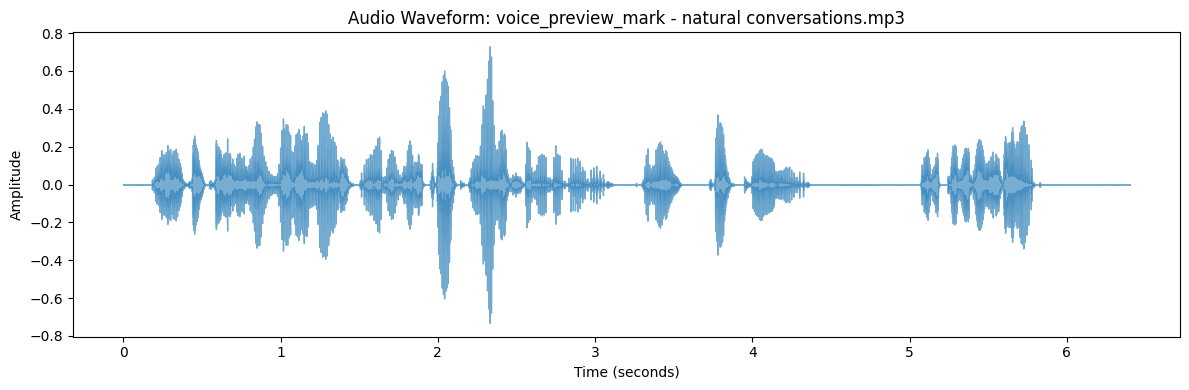

Duration: 6.40 seconds
Sample rate: 44100 Hz


In [ ]:
# Optional: Display waveform if librosa is available
try:
    import librosa  # type: ignore
    import librosa.display  # type: ignore
    import numpy as np
    
    if audio_file is not None and audio_file.exists():
        # Load audio
        y: np.ndarray
        sr: int
        y, sr = librosa.load(str(audio_file), sr=None)
        duration: float = librosa.get_duration(y=y, sr=sr)
        
        # Plot waveform
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y, sr=sr, alpha=0.6)
        plt.title(f"Audio Waveform: {audio_file.name}")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()
        
        print(f"Duration: {duration:.2f} seconds")
        print(f"Sample rate: {sr} Hz")
    
except ImportError:
    print("librosa not installed. Skipping waveform visualization.")
    print("   To enable: pip install librosa soundfile")
except Exception as e:
    print(f"Could not load audio: {e}")

## 3. Run Automatic Speech Recognition (ASR)

Transcribe the audio file using Whisper. This may take 10-30 seconds on first run (model loading).

In [ ]:
# Run ASR transcription
asr_result: Dict[str, Any]

if audio_file is not None and audio_file.exists():
    print(" Transcribing audio with Whisper ASR...")
    print(" (First run will download model ~150MB)")
    
    asr_result = transcribe(str(audio_file), model_size="small")
    
    print("\n" + "="*60)
    print("ASR RESULTS")
    print("="*60)
    print(f"\n Transcript:\n   \"{asr_result['transcript']}\"\n")
    print(f" Word count: {asr_result['word_count']}")
    print(f" Duration: {asr_result['duration_sec']} seconds")
    print(f" Language: {asr_result.get('language', 'en')}")
    print("="*60)
else:
    print("⚠ Skipping ASR - audio file not found")
    # Use example transcript for demonstration
    asr_result = {
        'transcript': (
            "Um, hello. My name is John and, you know, I am applying "
            "for this position. I has experience in data science."
        ),
        'word_count': 21,
        'duration_sec': 8.5,
        'language': 'en'
    }
    print(" Using example transcript for demonstration:")
    print(f"   \"{asr_result['transcript']}\"")

🎤 Transcribing audio with Whisper ASR...
   (First run will download model ~150MB)


## 4. Extract Text-Based Features

Analyze the transcript to extract grammar errors, filler words, and fluency metrics.

In [ ]:
# Normalize transcript
transcript: str = asr_result['transcript']
normalized_text: str = normalize_transcript(transcript)
word_count: int = asr_result['word_count']
duration_sec: float = asr_result['duration_sec']

print(" Extracting text features...\n")

# Extract grammar errors
grammar_error_count: int
grammar_details: List[Dict[str, Any]]
grammar_error_count, grammar_details = grammar_errors(normalized_text, language="en-US")

# Detect filler words
filler_word_count: int
filler_list: List[str]
filler_word_count, filler_list = filler_count(normalized_text)

# Calculate words per minute
wpm: float = words_per_minute(word_count, duration_sec)

print("="*60)
print("FEATURE EXTRACTION RESULTS")
print("="*60)
print(f"\n Grammar errors: {grammar_error_count}")
print(f" Filler words: {filler_word_count} - {filler_list}")
print(f" Speaking rate: {wpm} WPM")
print("="*60)

🔍 Extracting text features...



✓ Loaded LanguageTool for en-US
FEATURE EXTRACTION RESULTS

✏️  Grammar errors: 1
🗣  Filler words: 2 - ['you know', 'um']
⚡ Speaking rate: 148.24 WPM
FEATURE EXTRACTION RESULTS

✏️  Grammar errors: 1
🗣  Filler words: 2 - ['you know', 'um']
⚡ Speaking rate: 148.24 WPM


### 4.1 Grammar Error Details

Display detailed grammar errors in a readable format.

In [ ]:
if grammar_error_count > 0:
    # Create DataFrame for better visualization
    grammar_df: pd.DataFrame = pd.DataFrame([
        {
            'Rule ID': err['rule_id'],
            'Message': err['message'],
            'Context': (
                err['context'][:50] + '...'
                if len(err['context']) > 50
                else err['context']
            ),
            'Suggestions': (
                ', '.join(err['replacements'][:2])
                if err['replacements']
                else 'N/A'
            )
        }
        for err in grammar_details[:10]  # Show top 10
    ])
    
    print("\n Grammar Error Details:\n")
    print(grammar_df.to_string(index=False))
    
    if grammar_error_count > 10:
        print(f"\n... and {grammar_error_count - 10} more errors")
else:
    print("\n No grammar errors detected!")


📋 Grammar Error Details:

  Rule ID                                            Message                                               Context Suggestions
BASE_FORM Possible agreement error — use the base form here. ...now, I am applying for this position. I has exp...        have


## 5. Calculate Proficiency Score

Normalize all metrics and compute the weighted final score (0-100).

In [ ]:
# Normalize penalties
grammar_penalty: float = normalize_grammar_errors(grammar_error_count, word_count)
filler_penalty: float = normalize_fillers(filler_word_count, word_count)
wer_penalty: float = normalize_wer(None)  # No reference transcript in this demo
fluency_pen: float = fluency_penalty(wpm)

# Calculate final score
final_score: float = calculate_final_score(
    grammar_penalty=grammar_penalty,
    filler_penalty=filler_penalty,
    wer_penalty=wer_penalty,
    fluency_pen=fluency_pen
)

# Generate explanation
explanation: str = generate_score_explanation(
    grammar_penalty=grammar_penalty,
    filler_penalty=filler_penalty,
    wer_penalty=wer_penalty,
    fluency_pen=fluency_pen,
    final=final_score
)

print("\n" + "="*60)
print("SCORING RESULTS")
print("="*60)
print("\n Raw Metrics:")
print(
    f"   Grammar errors: {grammar_error_count} "
    f"({grammar_error_count/word_count*100:.1f} per 100 words)"
)
print(
    f"   Filler words: {filler_word_count} "
    f"({filler_word_count/word_count*100:.1f} per 100 words)"
)
print(f"   Speaking rate: {wpm} WPM")

print("\n Normalized Penalties [0=perfect, 1=worst]:")
print(f"   Grammar:  {grammar_penalty:.3f}")
print(f"   Fillers:  {filler_penalty:.3f}")
print(f"   WER:      {wer_penalty:.3f} (N/A - no reference)")
print(f"   Fluency:  {fluency_pen:.3f}")

print(f"\n FINAL SCORE: {final_score}/100")
print(f"\n {explanation}")
print("="*60)


SCORING RESULTS

📊 Raw Metrics:
   Grammar errors: 1 (4.8 per 100 words)
   Filler words: 2 (9.5 per 100 words)
   Speaking rate: 148.24 WPM

📉 Normalized Penalties [0=perfect, 1=worst]:
   Grammar:  0.397
   Fillers:  1.000
   WER:      0.000 (N/A - no reference)
   Fluency:  0.000

🎯 FINAL SCORE: 61.11/100

💬 Score: 61.11/100 | Grammar: -13.9 pts | Fillers: -25.0 pts | WER: -0.0 pts | Fluency: -0.0 pts


## 6. Score Visualization

Visualize the scoring breakdown using a radar chart.

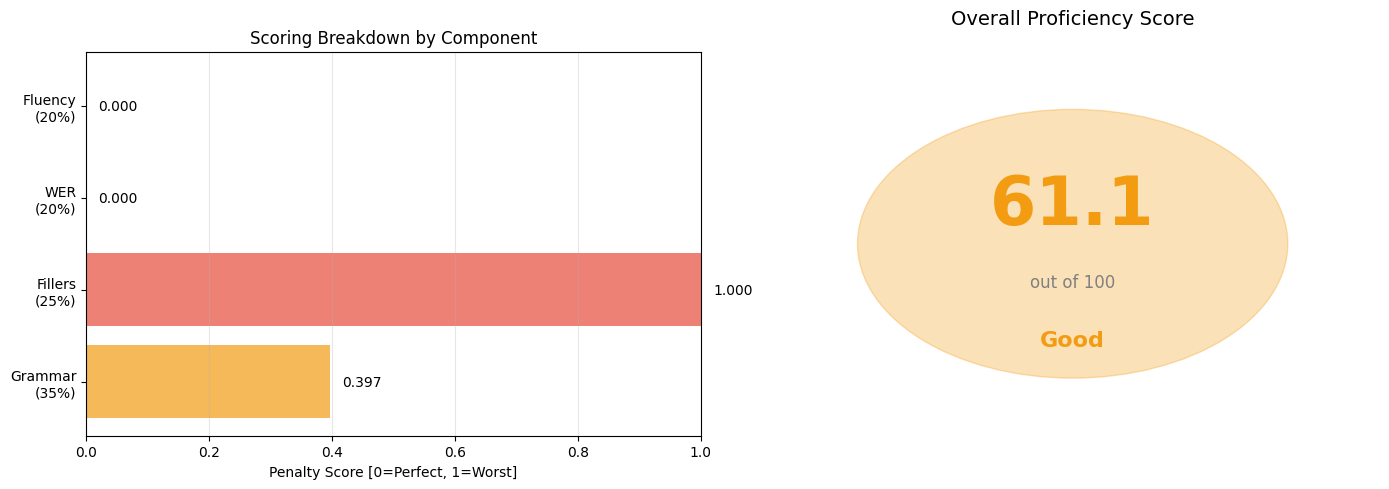


✅ Score visualization complete!


In [ ]:
# Prepare data for visualization
from matplotlib.patches import Circle  # type: ignore
from matplotlib.figure import Figure  # type: ignore
from matplotlib.axes import Axes  # type: ignore

categories: List[str] = [
    'Grammar\n(35%)', 'Fillers\n(25%)', 'WER\n(20%)', 'Fluency\n(20%)'
]
penalties: List[float] = [grammar_penalty, filler_penalty, wer_penalty, fluency_pen]
scores_component: List[float] = [(1 - p) * 100 for p in penalties]

# Create radar chart
fig: Figure
ax1: Axes
ax2: Axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of penalties
colors: List[str] = [
    '#e74c3c' if p > 0.5 else '#f39c12' if p > 0.25 else '#27ae60'
    for p in penalties
]
ax1.barh(categories, penalties, color=colors, alpha=0.7)
ax1.set_xlabel('Penalty Score [0=Perfect, 1=Worst]')
ax1.set_title('Scoring Breakdown by Component')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (cat, pen) in enumerate(zip(categories, penalties)):
    ax1.text(pen + 0.02, i, f'{pen:.3f}', va='center')

# Score gauge
ax2.axis('off')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# Draw score gauge
score_normalized: float = final_score / 100
color: str
grade: str

if score_normalized >= 0.8:
    color = '#27ae60'  # Green
    grade = 'Excellent'
elif score_normalized >= 0.6:
    color = '#f39c12'  # Orange
    grade = 'Good'
elif score_normalized >= 0.4:
    color = '#e67e22'  # Dark orange
    grade = 'Fair'
else:
    color = '#e74c3c'  # Red
    grade = 'Needs Improvement'

# Draw circle
circle: Circle = Circle((0.5, 0.5), 0.35, color=color, alpha=0.3)
ax2.add_patch(circle)

# Add score text
ax2.text(0.5, 0.6, f'{final_score:.1f}', 
         ha='center', va='center', fontsize=48, fontweight='bold',
         color=color)
ax2.text(0.5, 0.4, 'out of 100', 
         ha='center', va='center', fontsize=12, color='gray')
ax2.text(0.5, 0.25, grade, 
         ha='center', va='center', fontsize=16, fontweight='bold',
         color=color)
ax2.set_title('Overall Proficiency Score', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print(f"\n Score visualization complete!")

## 7. Batch Evaluation (Optional)

Process multiple audio files and compare scores.

In [ ]:
# Check if sample_audio directory exists and has multiple files
if audio_dir.exists():
    audio_files: List[Path] = (
        list(audio_dir.glob("*.wav")) + list(audio_dir.glob("*.mp3"))
    )
    
    if len(audio_files) > 1:
        print(
            f" Found {len(audio_files)} audio files. "
            "Running batch evaluation...\n"
        )
        
        results: List[Dict[str, Any]] = []
        
        for i, audio_path in enumerate(audio_files, 1):
            print(f"[{i}/{len(audio_files)}] Processing: {audio_path.name}...")
            
            try:
                # Run pipeline
                asr: Dict[str, Any] = transcribe(str(audio_path), model_size="small")
                transcript_batch: str = normalize_transcript(asr['transcript'])
                
                # Extract features
                g_count: int
                f_count: int
                g_count, _ = grammar_errors(transcript_batch)
                f_count, _ = filler_count(transcript_batch)
                wpm_val: float = words_per_minute(
                    asr['word_count'], asr['duration_sec']
                )
                
                # Compute score
                g_pen: float = normalize_grammar_errors(g_count, asr['word_count'])
                f_pen: float = normalize_fillers(f_count, asr['word_count'])
                fl_pen: float = fluency_penalty(wpm_val)
                
                score: float = calculate_final_score(g_pen, f_pen, 0.0, fl_pen)
                
                results.append({
                    'File': audio_path.name,
                    'Words': asr['word_count'],
                    'Duration (s)': asr['duration_sec'],
                    'Grammar Errors': g_count,
                    'Fillers': f_count,
                    'WPM': wpm_val,
                    'Score': score
                })
                
            except Exception as e:
                print(f"   ⚠ Error: {e}")
        
        # Display results
        if results:
            df: pd.DataFrame = pd.DataFrame(results)
            df = df.sort_values('Score', ascending=False)
            
            print("\n" + "="*80)
            print("BATCH EVALUATION RESULTS (sorted by score)")
            print("="*80)
            print(df.to_string(index=False))
            print("="*80)
            
            # Summary statistics
            print(f"\n Summary Statistics:")
            print(f"   Average score: {df['Score'].mean():.2f}")
            print(
                f"   Score range: {df['Score'].min():.2f} - "
                f"{df['Score'].max():.2f}"
            )
            print(f"   Avg grammar errors: {df['Grammar Errors'].mean():.1f}")
            print(f"   Avg fillers: {df['Fillers'].mean():.1f}")
    else:
        print(
            f" Only 1 audio file found. Add more files to {audio_dir} "
            "for batch evaluation."
        )
else:
    print(f" Sample audio directory not found: {audio_dir}")
    print(f"   Skipping batch evaluation.")

📁 Sample audio directory not found: d:\Grammar Scoring from Voice Samples\data\sample_audio
   Skipping batch evaluation.


## 8. Insights and Next Steps

### Key Findings

This demo illustrates the complete grammar scoring pipeline, from raw audio to interpretable proficiency scores. The system provides:

1. **Transparent scoring**: Each component (grammar, fillers, fluency) is weighted based on linguistic research
2. **Actionable feedback**: Grammar errors include specific suggestions for improvement
3. **Standardized assessment**: Scores are normalized to 0-100 scale for easy interpretation

### Limitations and Considerations

- **ASR Accuracy**: Whisper may introduce transcription errors, especially with accents or background noise
- **Grammar Checker**: LanguageTool is rule-based and may miss context-dependent errors
- **Filler Words**: Some "fillers" (like "well", "so") can be natural discourse markers
- **Fluency Complexity**: WPM alone doesn't capture pause patterns or prosody
- **Bias and Fairness**: Non-native speakers and dialect variations may be unfairly penalized

### Future Enhancements

1. **Accent-robust ASR**: Fine-tune Whisper on diverse accent data
2. **Contextual grammar**: Use transformer-based models (e.g., LanguageTool + GPT)
3. **Pause analysis**: Add silence detection for more nuanced fluency scoring
4. **Reference comparisons**: Enable WER calculation with reference transcripts
5. **Calibration**: Validate scoring weights against human expert ratings

### Production Deployment

For production use via API:
```bash
uvicorn app.main:app --reload
```

Then send audio files to `POST /score` endpoint.

---

**Project developed for SHL AI Research Internship | 2025**